# Color quantization & first evaluation of color histogram classifier

## Loading the data

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from ipywidgets import interact
import ipywidgets as widgets

from dobble_master_race.toolkit import get_data_set

In [2]:
X, Y = get_data_set()
X.shape, Y.shape

((285,), (285,))

## What the data looks like ?

In [3]:
nb_class = np.max(Y)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
    for i, x in enumerate(X[Y == class_]):
        ax_arr[i].imshow(x)

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

# Color reduction

## Image mask

In [4]:
gray_threshold = 245

masks = np.array([
    img.sum(axis=-1) < (gray_threshold * 3)
    for img in X
], dtype=object)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
    for i, mask in enumerate(masks[Y == class_]):
        ax_arr[i].imshow(mask, cmap='gray')

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

## Sampling pixels

In [5]:
nb_sample = 50000

nb_images_per_class = 5
nb_images = nb_class * nb_images_per_class
nb_sample_per_image = nb_sample // nb_images

sample_pxls = X[0][masks[0]][0] # Initialize arbitrary to be able to use np.vstack
for img, mask in zip(X[1:], masks[1:]):
    pxls = img[mask]
    new_sample_pxls_id = np.random.choice(pxls.shape[0], size=nb_sample_per_image, replace=False)
    sample_pxls = np.vstack((sample_pxls, pxls[new_sample_pxls_id]))

sample_pxls.shape, sample_pxls.dtype

((49701, 3), dtype('uint8'))

## Selecting color quantization threshold

In [6]:
from sklearn.cluster import KMeans
from tqdm import tqdm

# How to choose the right number of colors ?

inertias = []
new_colors = []
color_models = []
color_range = (2, 40)

# Compute new_colors and inertias and color_models
for i in tqdm(range(*color_range)):
    kmeans = KMeans(n_clusters=i, random_state=42)
    
    kmeans.fit(sample_pxls)
    inertias.append(kmeans.inertia_)
    
    new_color = kmeans.cluster_centers_.astype(np.uint8)
    new_colors.append(new_color)
    
    color_models.append(kmeans)

100%|█████████████████████████████████████████████████████████████████████| 38/38 [05:49<00:00,  9.21s/it]


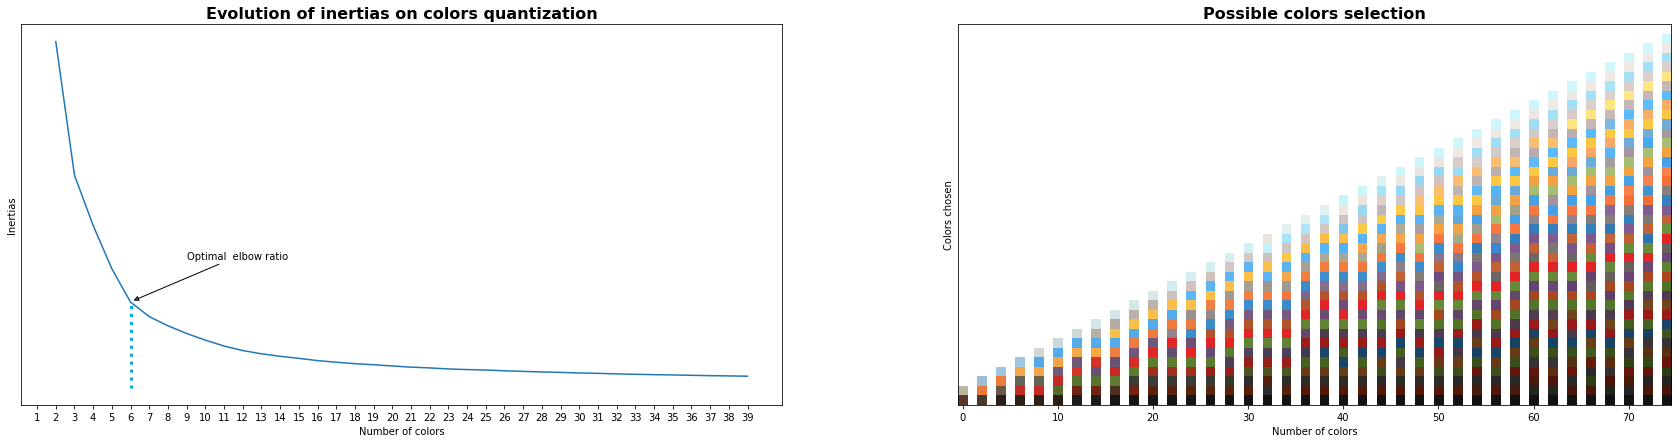

In [7]:
nb_opti_color = 6
_, ax_arr = plt.subplots(ncols=2, figsize=(30,7))
    
# Plot new_colors
nb_tested_colors = color_range[1] - color_range[0]
new_color_img = np.full(shape=(color_range[1], 2 * nb_tested_colors - 1, 3), fill_value=255)

for i, new_color in enumerate(new_colors):
    new_color_img[:new_color.shape[0], i * 2] = np.array(sorted(new_color, key=lambda color: color[0] / 3 + color[1] / 3 + color[2] / 3))[np.newaxis, ...]

ax_arr[1].imshow(new_color_img, origin='lower')
ax_arr[1].set_title("Possible colors selection", fontsize=16, fontweight="semibold")
ax_arr[1].set_xlabel("Number of colors")
ax_arr[1].set_ylabel("Colors chosen")
ax_arr[1].set_yticklabels([]); ax_arr[1].set_yticks([])

# Plot inertias
ax_arr[0].plot(range(*color_range), inertias)
ax_arr[0].set_title("Evolution of inertias on colors quantization", fontsize=16, fontweight="semibold")
ax_arr[0].set_xlabel("Number of colors")
ax_arr[0].set_ylabel("Inertias")
ax_arr[0].set_yticklabels([]); ax_arr[0].set_yticks([])
ax_arr[0].set_xticks(range(color_range[-1]))
ax_arr[0].plot([nb_opti_color, nb_opti_color],[0, inertias[nb_opti_color - color_range[0]]],':', color = '#00aadd', lw=3)
ax_arr[0].annotate(r"Optimal  elbow ratio", xy=(nb_opti_color * 1.01, inertias[nb_opti_color - color_range[0]] * 1.01),
                   xytext=(nb_opti_color * 1.5, inertias[nb_opti_color - color_range[0]] * 1.5), arrowprops=dict(arrowstyle="-|>"));

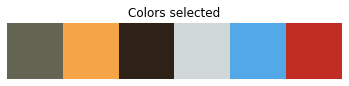

In [8]:
# Example of color sampling
nb_color = nb_opti_color

color_model = color_models[nb_color - color_range[0]]
new_color_lut = new_colors[nb_color - color_range[0]]

plt.imshow(new_color_lut[np.newaxis, :, :]); plt.axis("off"); plt.title("Colors selected");

In [9]:
import sklearn

def get_color_maps(X: np.array, masks: np.array, color_model: sklearn.cluster) -> np.array:
    return np.array([
        color_model.predict(img[mask])
        for img, mask in zip(X, masks)
    ], dtype=object)

color_maps = get_color_maps(X, masks, color_model)

def get_recolored_img(img: np.array, mask: np.array, color_map: np.array) -> np.array:
    recolored_img = np.full_like(img, 255)
    recolored_img[mask] = new_color_lut[color_map]
    
    return recolored_img

def recolor_X(X: np.array, masks: np.array, color_model: sklearn.cluster, *, color_maps: np.array = None) -> np.array:
    if (color_maps is None):
        color_maps = get_color_maps(X, masks, color_model)
    return np.array([
        get_recolored_img(img, mask, color_map)
        for img, mask, color_map in zip(X, masks, color_maps)
    ], dtype=object)

recolored_X = recolor_X(X, masks, color_model)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    fig = plt.figure(constrained_layout=True, figsize=(12,4))
    subfigs = fig.subfigures(nrows=2, ncols=1)
    ax_recolored = subfigs[0].subplots(nrows=1, ncols=nb_images_per_class); subfigs[0].suptitle("Recolored", fontsize=16)
    ax_original  = subfigs[1].subplots(nrows=1, ncols=nb_images_per_class); subfigs[1].suptitle("Original", fontsize=16)
    
    for i, (recolored_x, x) in enumerate(zip(recolored_X[Y == class_], X[Y == class_])):
        ax_recolored[i].imshow(recolored_x)
        ax_original[i].imshow(x)
        ax_recolored[i].axis("off"); ax_original[i].axis("off")

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

## Compute the color histograms

In [10]:
def get_hist(color_map: np.array, *, nb_color=nb_color) -> np.array:
    hist = np.bincount(color_map, minlength=nb_color)
    norm_hist = hist / color_map.shape[0]
    
    return norm_hist

def compute_histograms(color_maps: np.array, *, nb_color=nb_color) -> np.array:
    return np.array([get_hist(color_map, nb_color=nb_color) for color_map in color_maps], dtype=object)

color_histograms = compute_histograms(color_maps)
color_histograms[0]

array([0.05985543018335684, 0.3488187588152327, 0.3104724964739069,
       0.04724964739069112, 8.815232722143864e-05, 0.23351551480959098],
      dtype=object)

In [11]:
colors_for_bars = new_color_lut / 255  # matplotlib colors are RGB values scaled to [0,1]

@interact(x_index=widgets.BoundedIntText(max=X.shape[0]))
def show_histograms(x_index: int) -> None:
    plt.figure(figsize=(8,4))
    plt.subplot(1,3,1)
    plt.imshow(X[x_index])
    plt.axis('off'); plt.title("Original")
    plt.subplot(1,3,2)
    plt.imshow(recolored_X[x_index])
    plt.axis('off'); plt.title("Recolored")
    plt.subplot(1,3,3, aspect=len(color_histograms[0]))
    plt.ylim(0, 1)
    plt.bar(range(len(color_histograms[x_index])), 
            color_histograms[x_index] / color_histograms[x_index].max(), 
            color=colors_for_bars)
    plt.xticks([]); plt.title("Histogram")
    plt.show()

interactive(children=(BoundedIntText(value=0, description='x_index', max=285), Output()), _dom_classes=('widge…

## Compute the distance matrix
Because color histograms are **very compact**, it is **very fast** to compute the distance matrix (even if the complexity is $O(n^2)$).

In [12]:
from scipy.spatial.distance import cosine

dist_mat = np.ones((len(X), len(X))) # distances will be between 0 (closest) and 1 (farthest)
for i in range(len(X)):
    for j in range(len(X)):
        dist_mat[i,j] = cosine(color_histograms[i], color_histograms[j])

Correct the diagonal to avoid getting the same result over and over: we set the distance of one element against itself to the maximum distance.

In [13]:
dist_mat[np.diag_indices_from(dist_mat)] = 1

In [14]:
idx_of_best_matches_per_row = np.argsort(dist_mat, axis=1)

## Find the best matches for each image

In [15]:
nb_images_displayed = 5

@interact(x_index=widgets.BoundedIntText(max=X.shape[0] - 1))
def show_similar_images(x_index: int) -> None:
    plt.figure(figsize=(12,8))
    nb_columns = nb_images_displayed + 1
    
    plt.subplot(1, nb_columns, 1)
    plt.imshow(recolored_X[x_index])
    plt.axis("off")
    plt.title("Original")
    
    for image_id in range(nb_images_displayed):
        idx = idx_of_best_matches_per_row[x_index, image_id]
        plt.subplot(1, nb_columns, image_id + 2)
        plt.imshow(recolored_X[idx])
        plt.axis("off")
        plt.title(f"({dist_mat[x_index, idx]: .6f})")

interactive(children=(BoundedIntText(value=0, description='x_index', max=284), Output()), _dom_classes=('widge…

A priori le nb de trous n'est pas ideal en second discriminateur. Contre-example:
- 0
- Peut-etre le 10 (jsp si 2 ou 3 trous)

Idees d'amelioration:
- Tester d'autres distances
- Reduire la "Color quantization" (a.k.a augmenter le nbr de couleurs) pour avoir une distance d'histogramme plus perinente
- Discrimineur de formes
- Tester
    - Soit d'augmenter le nombre de couleurs pour avoir un histogram + precis
    - Soit de tester des discriminateurs de formes

# Classifier base on image color histogram

## Metrics
We base our evaluation system on solid, well-knowed metrics:
- Precision
- Recall
- F1-score
- Confusion Matrix

To mitigate the effect of the small size of the dataset on the evaluation, we have chosen to use a 5-cross-validation.\
This will keep under-control the high variance of performance such a dataset could have.\
The 5-cross-validation automatically separates the training and the testing set and evaluates the model on it for 5 different configuration.\
Checkout the [wikipedia page](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) to know more.

In [73]:
import pandas as pd
import seaborn as sn

def print_confusion_matrix(predicted: np.array, actual: np.array) -> None:
    """
    Print the confusion matrix for the `predicted` outputs vs the `actual` ones.
    """
    old_figsize = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = (15,15)
    confusion_matrix = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'], margins=True)
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=True, bottom=True, top=True, labeltop=True)
    sn.heatmap(confusion_matrix, annot=True, vmax=np.max(confusion_matrix.max()[:-1]))
    plt.show()
    plt.rcParams["figure.figsize"] = old_figsize

def get_perf_on_cross_validation(model) -> None:
    """
    Compute & print the following metrics with an average on a 5-cross-validation for the given `model`:
    - Precision
    - Recall
    - F1-score
    - Confusion Matrix
    """
    model_perf = cross_validate(model, color_histograms, Y, cv=nb_images_per_class,
                                scoring=['recall_micro', 'precision_micro', 'f1_micro'], return_estimator=True)
    best_model = model_perf["estimator"][np.argmax(model_perf["test_f1_micro"])]
    
    print(f"Recall: {np.mean(model_perf['test_recall_micro'])}")
    print(f"Precision: {np.mean(model_perf['test_precision_micro'])}")
    print(f"F1-score: {np.mean(model_perf['test_f1_micro'])}")
    
    print_confusion_matrix(best_model.predict(color_histograms), Y)    

### Dummy baseline
The goal of this baseline is to illustrate the performance of a random classifier.
This will demonstrate the performance of our implementation.

Recall: 0.010526315789473684
Precision: 0.010526315789473684
F1-score: 0.010526315789473684


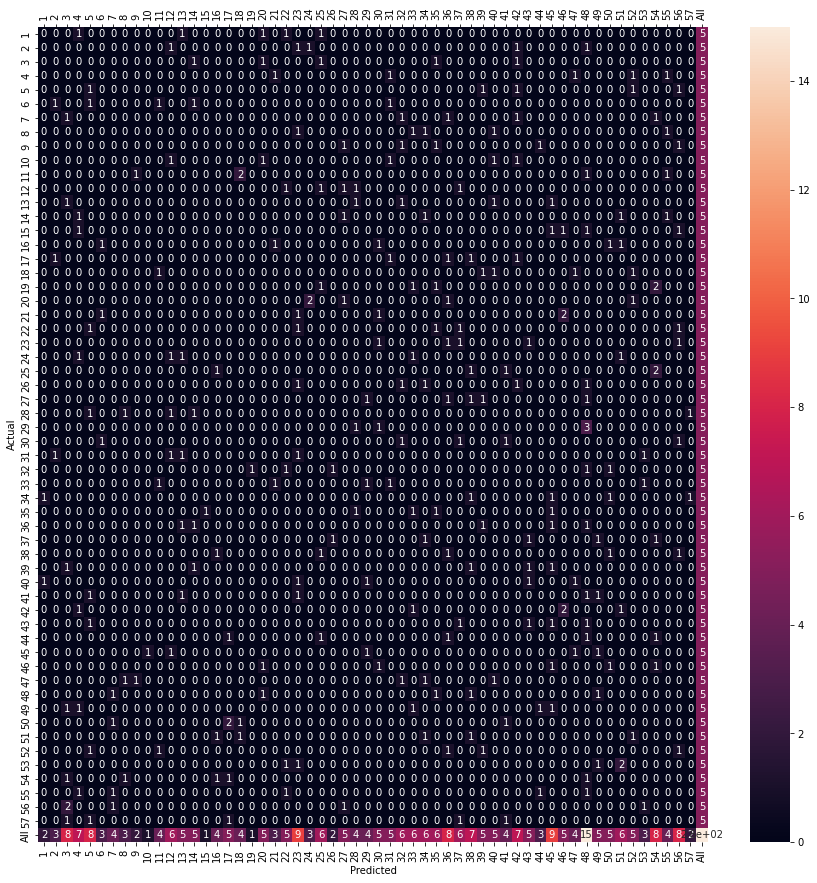

In [74]:
class DummyClassifier:
    """
    Return a random class for each entry
    """
    def fit(self, X: np.array, Y: np.array) -> "DummyClassifier":
        return self
    
    def get_params(self, deep=True) -> dict:
        return {}
    
    def predict(self, X: np.array) -> np.array:
        return np.random.randint(low=1, high=nb_class + 1, size=X.shape[0])

dummy = DummyClassifier()
get_perf_on_cross_validation(dummy)

## The classifiers
We based our choice of classifiers on the sklearn cheat-sheet.\
We have therefore tried in our implementation:
- LinearSVC
- KNN
- SVC
- Random Forest

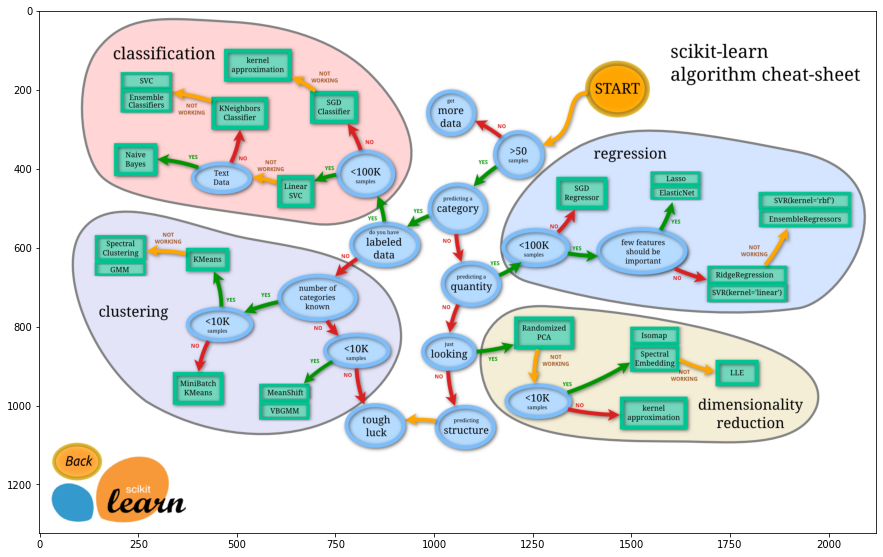

In [16]:
from PIL import Image
import urllib
from matplotlib import pyplot as plt

img = np.array(Image.open(urllib.request.urlopen("https://scikit-learn.org/stable/_static/ml_map.png")))
old_fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (15,15)
plt.imshow(img)
plt.rcParams["figure.figsize"] = old_fig_size;

In [17]:
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC

linear_svc = LinearSVC()
cross_validate(linear_svc, color_histograms, Y, cv=5)["test_score"]

array([0.29824561, 0.28070175, 0.29824561, 0.26315789, 0.29824561])

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn_models = cross_validate(knn, color_histograms, Y, cv=5, return_estimator=True)
best_knn = knn_models["estimator"][np.argmax(knn_models["test_score"])]
knn_models["test_score"]

array([0.80701754, 0.87719298, 0.85964912, 0.8245614 , 0.85964912])

In [19]:
from sklearn.svm import SVC

svc = SVC()
svc_models = cross_validate(svc, color_histograms, Y, cv=5, return_estimator=True)
best_svc = svc_models["estimator"][np.argmax(svc_models["test_score"])]
svc_models["test_score"]

array([0.75438596, 0.84210526, 0.80701754, 0.89473684, 0.84210526])

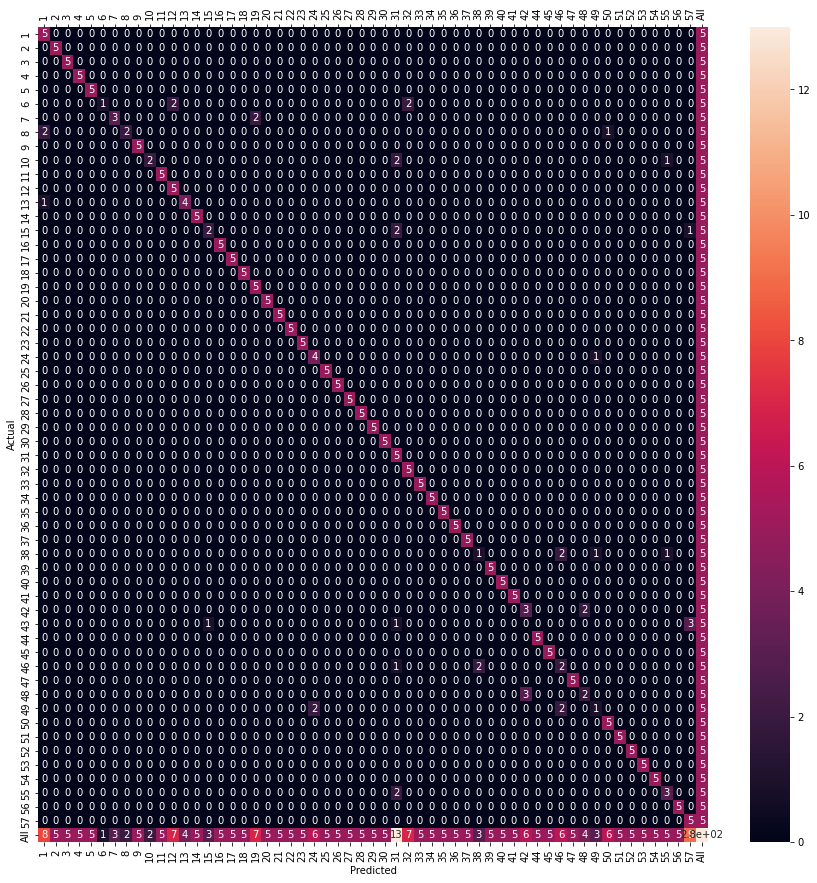

On voit la class 6 (Le bon homme de neige) est confondu avec les class 12 et 32, respectivement le Fantome et le Crayon.
Ce qui est logique comme ils ont tous les 3 des couleurs tres similaires.

## Peut-on ameliorer les resultats du classifier en changeant la color quanitzation ?

In [31]:
def recolor_and_compute_histograms(X: np.array, masks: np.array, color_model: sklearn.cluster, *, nb_color) -> np.array:
    color_maps = get_color_maps(X, masks, color_model)
    return compute_histograms(color_maps, nb_color=nb_color)

def get_score(classifier, color_histograms: np.array, Y: np.array) -> float:
    return max(cross_validate(classifier, color_histograms, Y, cv=5)["test_score"])

linear_svc_perf = []
svc_perf = []
knn_perf = []

for nb_color, color_model in tqdm(list(enumerate(color_models, start=color_range[0]))):
    new_color_histograms = recolor_and_compute_histograms(X, masks, color_model, nb_color=nb_color)
    linear_svc_perf.append(get_score(linear_svc, new_color_histograms, Y))
    svc_perf.append(get_score(svc, new_color_histograms, Y))
    knn_perf.append(get_score(knn, new_color_histograms, Y))

100%|█████████████████████████████████████████████████████████████████████| 38/38 [00:41<00:00,  1.10s/it]


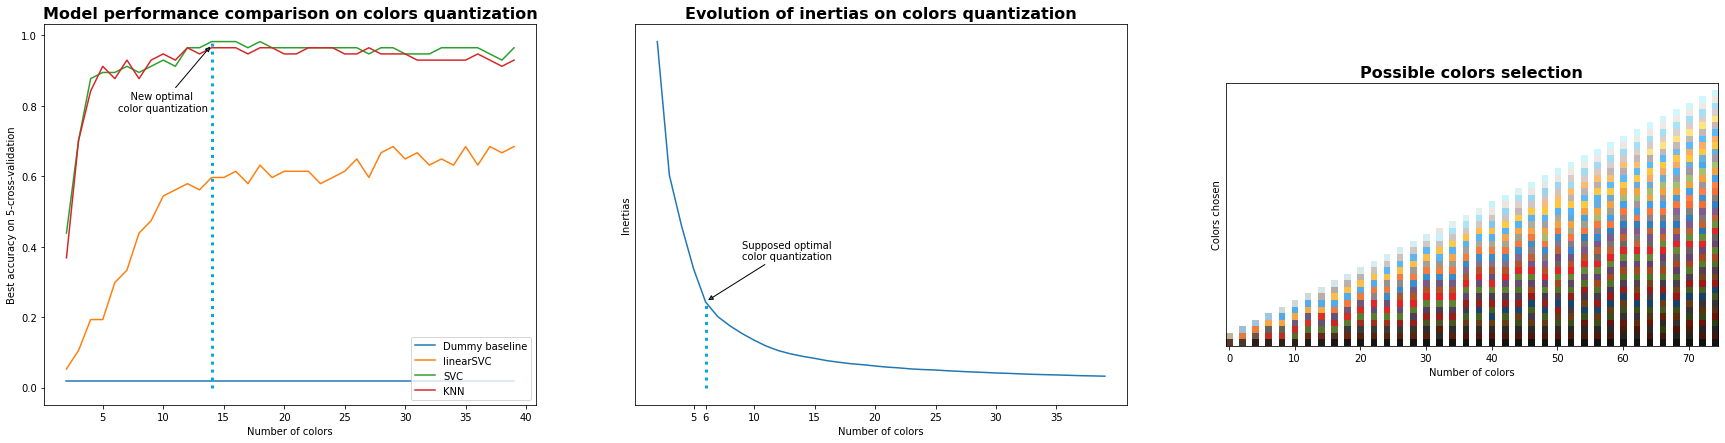

In [26]:
nb_opti_color = 6
_, ax_arr = plt.subplots(ncols=3, figsize=(30,7))
    
# Plot new_colors
nb_tested_colors = color_range[1] - color_range[0]
new_color_img = np.full(shape=(color_range[1], 2 * nb_tested_colors - 1, 3), fill_value=255)

for i, new_color in enumerate(new_colors):
    new_color_img[:new_color.shape[0], i * 2] = np.array(sorted(new_color, key=lambda color: color[0] / 3 + color[1] / 3 + color[2] / 3))[np.newaxis, ...]

ax_arr[2].imshow(new_color_img, origin='lower')
ax_arr[2].set_title("Possible colors selection", fontsize=16, fontweight="semibold")
ax_arr[2].set_xlabel("Number of colors")
ax_arr[2].set_ylabel("Colors chosen")
ax_arr[2].set_yticklabels([]); ax_arr[2].set_yticks([])

# Plot inertias
ax_arr[1].plot(range(*color_range), inertias)
ax_arr[1].set_title("Evolution of inertias on colors quantization", fontsize=16, fontweight="semibold")
ax_arr[1].set_xlabel("Number of colors")
ax_arr[1].set_ylabel("Inertias")
ax_arr[1].set_yticklabels([]); ax_arr[1].set_yticks([])
ax_arr[1].set_xticks(list(range(0, color_range[-1], 5)) + [6])
ax_arr[1].plot([nb_opti_color, nb_opti_color],[0, inertias[nb_opti_color - color_range[0]]],':', color = '#00aadd', lw=3)
ax_arr[1].annotate("Supposed optimal\ncolor quantization", xy=(nb_opti_color * 1.01, inertias[nb_opti_color - color_range[0]] * 1.01),
                   xytext=(nb_opti_color * 1.5, inertias[nb_opti_color - color_range[0]] * 1.5), arrowprops=dict(arrowstyle="-|>"))

# Plots classifiers performance
new_nb_opti_color = np.argmax(svc_perf) + color_range[0]
ax_arr[0].set_title("Model performance comparison on colors quantization", fontsize=16, fontweight="semibold")
ax_arr[0].set_xlabel("Number of colors")
ax_arr[0].set_ylabel("Best accuracy on 5-cross-validation")
ax_arr[0].plot(range(*color_range), [1 / nb_class] * (color_range[1] - color_range[0]), label="Dummy baseline")
ax_arr[0].plot(range(*color_range), linear_svc_perf, label="linearSVC")
ax_arr[0].plot(range(*color_range), svc_perf, label="SVC")
ax_arr[0].plot(range(*color_range), knn_perf, label="KNN")
ax_arr[0].legend(loc="lower right")
ax_arr[0].plot([new_nb_opti_color, new_nb_opti_color],[0, svc_perf[new_nb_opti_color]],':', color = '#00aadd', lw=3)
ax_arr[0].annotate("    New optimal\ncolor quantization", xy=(new_nb_opti_color, svc_perf[new_nb_opti_color] * 0.99),
                   xytext=(new_nb_opti_color * 0.45, svc_perf[new_nb_opti_color] * 0.8), arrowprops=dict(arrowstyle="-|>"));

First, it is good to note that all classifiers largely outperforms the dummy baseline.\
Also, the SVC seems to outperforms the KNN and LinearSVC methods for higher color quantization. \
We can also see that beyond a color quantization of 15 colors, the models does not seems to improve anymore (and even starts to underperform for KNN and SVC). \
Therefore, we will keep this threashold for latter experiments, as it seems to ne an optimal threashold between precision and performance.